# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from compositeNUVs.models.hiModel import HiModel

# Data Generation

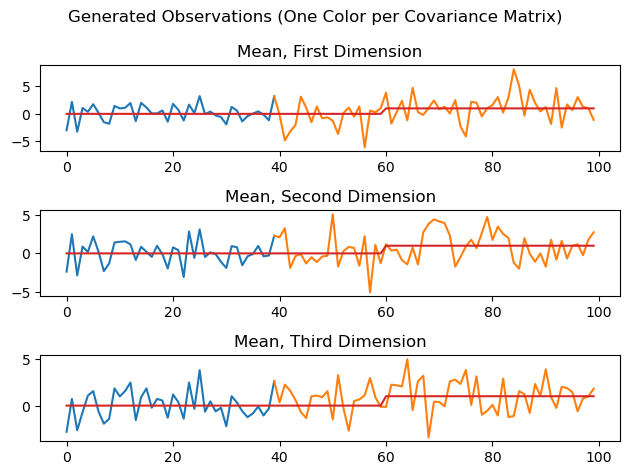

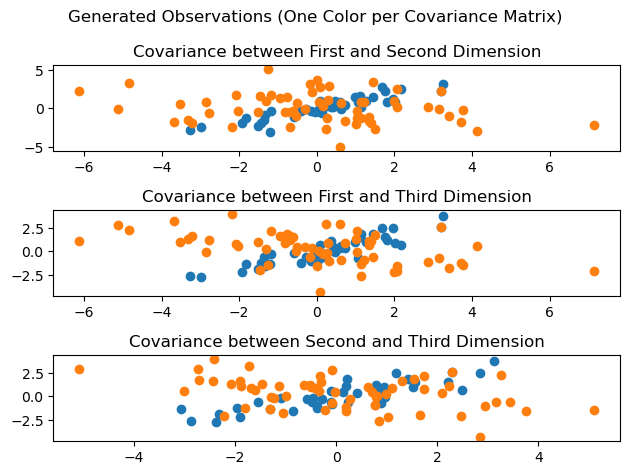

In [2]:
# Specify Parameters
N = 100
D = 3
seed = 1
np.random.seed(seed)

# Specifying model indices
selectedModel_mean = np.concatenate((np.zeros(int(0.6*N), dtype=int), np.ones(int(0.4*N), dtype=int)), axis=0)
selectedModel_cov = np.concatenate((np.zeros(int(0.4*N), dtype=int), np.ones(int(0.6*N), dtype=int)), axis=0)

means = np.array([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])
covNoises = np.array([
    [[1.0, 0.9, 0.9], [0.9, 1.0, 0.9], [0.9, 0.9, 1.0]], 
    [[1.5, -0.25, -0.5], [-0.25, 1.25, -0.5], [-0.5, -0.5, 1.0]]])*3

# Generate X, sigmas, and Y
x = np.array([means[selectedModel_mean_i] for selectedModel_mean_i in selectedModel_mean])
sigmas = np.array([covNoises[selectedModel_cov_i] for selectedModel_cov_i in selectedModel_cov])
y = np.array([
    np.random.multivariate_normal(means[selectedModel_mean_i], covNoises[selectedModel_cov_i]) 
    for selectedModel_mean_i, selectedModel_cov_i in zip(selectedModel_mean, selectedModel_cov)])
    
# Plot data
covChanges_ind = []
for i in range(1,N):
    if selectedModel_cov[i-1] != selectedModel_cov[i]:
        covChanges_ind.append(i)
covChanges_ind.append(N)

fig11, axs1 = plt.subplots(3,1)
fig12, axs2 = plt.subplots(3,1)

# Make plots with one color per covarinace matrix
start_ind = 0
for end_ind in covChanges_ind:
    axs1[0].plot(np.arange(start_ind, end_ind), y[start_ind:end_ind, 0])
    axs1[1].plot(np.arange(start_ind, end_ind), y[start_ind:end_ind, 1])
    axs1[2].plot(np.arange(start_ind, end_ind), y[start_ind:end_ind, 2])
    axs2[0].scatter(y[start_ind:end_ind,0]-x[start_ind:end_ind,0], 
                  y[start_ind:end_ind,1]-x[start_ind:end_ind,1])
    axs2[1].scatter(y[start_ind:end_ind,0]-x[start_ind:end_ind,0], 
                  y[start_ind:end_ind,2]-x[start_ind:end_ind,2])
    axs2[2].scatter(y[start_ind:end_ind,1]-x[start_ind:end_ind,1], 
                  y[start_ind:end_ind,2]-x[start_ind:end_ind,2])
    start_ind = end_ind-1
axs1[0].plot(x[:,0], c='tab:red')
axs1[1].plot(x[:,1], c='tab:red')
axs1[2].plot(x[:,2], c='tab:red')

# Describe plot
axs1[0].set_title('Mean, First Dimension')
axs1[1].set_title('Mean, Second Dimension')
axs1[2].set_title('Mean, Third Dimension')
axs2[0].set_title('Covariance between First and Second Dimension')
axs2[1].set_title('Covariance between First and Third Dimension')
axs2[2].set_title('Covariance between Second and Third Dimension')
fig11.suptitle('Generated Observations (One Color per Covariance Matrix)')
fig11.tight_layout()
fig12.suptitle('Generated Observations (One Color per Covariance Matrix)')
fig12.tight_layout()

# Estimation

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\lucai\nuvPriors_repo\nuvPriors\src\models\pwcModel.py:398: RuntimeWarning: divide by zero encountered in divide
  np.abs(mx_hat_new - self.mx_hat) / np.abs(self.mx_hat))
C:\Users\lucai\nuvPriors_repo\nuvPriors\src\models\covModel.py:134: RuntimeWarning: divide by zero encountered in divide
  np.abs(mj_hat - mj_hat_new) / np.abs(mj_hat))
  6%|████▉                                                                             | 6/100 [00:00<00:12,  7.40it/s]


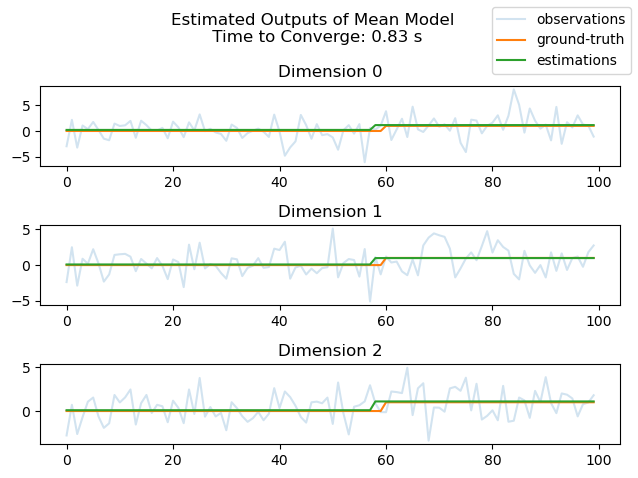

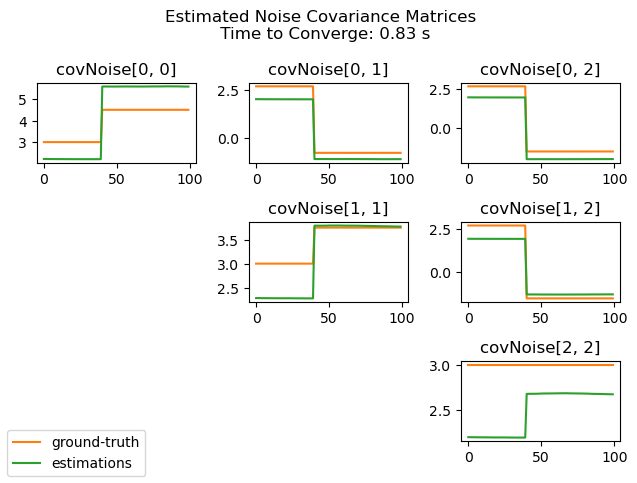

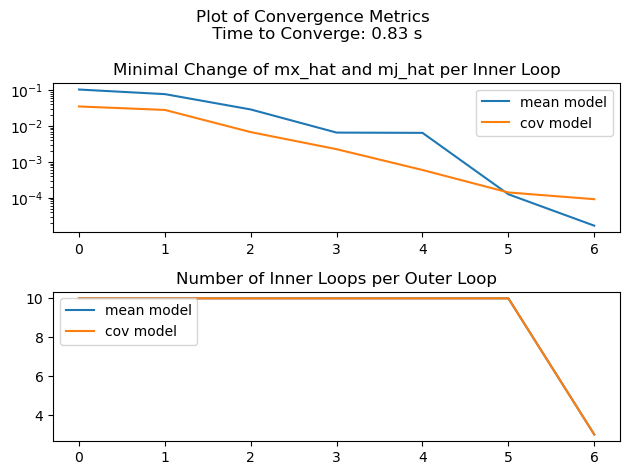

In [3]:
# Specify parameters
beta_u_mean = 5.0
beta_u_cov = 7.0

########################################################################################################################

# Initialize estimator
estimator = HiModel(N=N, D=D)

# Do estimation
performanceMetrics, i_it, conv_time = estimator.estimate_output(
    y=y, beta_u_mean=beta_u_mean, beta_u_cov=beta_u_cov)

########################################################################################################################

# Plot mean estimations
mx_hat, _ = estimator.get_xHat()

fig2, axs2 = plt.subplots(3, 1, squeeze=False)

# Iterate through all axes
for ax, i in zip(axs2[:,0], range(3)):
    ax.plot(y[:,i], alpha=0.2)
    ax.plot(x[:,i])
    ax.plot(mx_hat[:,i])
    ax.set_title(f'Dimension {i}')

fig2.suptitle(
    f'Estimated Outputs of Mean Model \n Time to Converge: ' + \
    f'{round(conv_time, 2)} s')
fig2.legend(['observations', 'ground-truth', 'estimations'])
fig2.tight_layout()

########################################################################################################################

# Plot covariance matrix estimations
sigmas_hat = estimator.get_sigmasHat()

fig3, axs3 = plt.subplots(3,3, squeeze=False)

# Delete subplots that are not in upper-triangular
for i in range(3):
    for j in range(i):
        axs3[i,j].remove()

# Iterate through remaining axes
for i in range(3):
    for j in range(i,3):
        axs3[i,j].plot(sigmas[:,i,j], c='tab:orange')
        axs3[i,j].plot(sigmas_hat[:,i,j], c='tab:green')
        axs3[i,j].set_title(f'covNoise[{i}, {j}]')

fig3.suptitle(
    f'Estimated Noise Covariance Matrices \n Time to Converge: {round(conv_time, 2)} s')
fig3.legend(['ground-truth', 'estimations'], loc='lower left')
fig3.tight_layout()

########################################################################################################################

# Plot convergence metrics
fig4, axs4 = plt.subplots(2,1)

axs4[0].plot(performanceMetrics['change_mean'])
axs4[0].plot(performanceMetrics['change_cov'])
axs4[0].set_yscale('log')
axs4[0].legend(['mean model', 'cov model'])
axs4[0].set_title('Minimal Change of mx_hat and mj_hat per Inner Loop')

axs4[1].plot(performanceMetrics['i_it_mean']+1)
axs4[1].plot(performanceMetrics['i_it_cov']+1)
axs4[1].legend(['mean model', 'cov model'])
axs4[1].set_title('Number of Inner Loops per Outer Loop')

fig4.suptitle(
    f'Plot of Convergence Metrics \n Time to Converge: {round(conv_time, 2)} s')
fig4.tight_layout()